In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import folium
from folium import plugins
import os
import shutil

from timeit import default_timer as timer

import warnings
warnings.filterwarnings('ignore')

#!pip install jupyternotify
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
## Run %%notify to create notification for completed cell

<IPython.core.display.Javascript object>

In [2]:
station = pd.read_csv('Data/cycle-share-dataset/station.csv')
trip = pd.read_csv('Data/cycle-share-dataset/trip.csv', error_bad_lines=False)
weather = pd.read_csv('Data/cycle-share-dataset/weather.csv', parse_dates=[0], index_col=[0])

b'Skipping line 50794: expected 12 fields, saw 20\n'


In [3]:
station.head()

station_id                    name        lat        long install_date  \
0      BT-01      3rd Ave & Broad St  47.618418 -122.350964   10/13/2014   
1      BT-03       2nd Ave & Vine St  47.615829 -122.348564   10/13/2014   
2      BT-04  6th Ave & Blanchard St  47.616094 -122.341102   10/13/2014   
3      BT-05  2nd Ave & Blanchard St  47.613110 -122.344208   10/13/2014   
4     CBD-03      7th Ave & Union St  47.610731 -122.332447   10/13/2014   

   install_dockcount modification_date  current_dockcount decommission_date  
0                 18               NaN                 18               NaN  
1                 16               NaN                 16               NaN  
2                 16               NaN                 16               NaN  
3                 14               NaN                 14               NaN  
4                 20               NaN                 20               NaN

In [4]:
station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 9 columns):
station_id           58 non-null object
name                 58 non-null object
lat                  58 non-null float64
long                 58 non-null float64
install_date         58 non-null object
install_dockcount    58 non-null int64
modification_date    17 non-null object
current_dockcount    58 non-null int64
decommission_date    4 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 4.2+ KB


In [5]:
station['install_date'] = pd.to_datetime(station['install_date'])

In [6]:
trip.head()

trip_id         starttime          stoptime    bikeid  tripduration  \
0      431  10/13/2014 10:31  10/13/2014 10:48  SEA00298       985.935   
1      432  10/13/2014 10:32  10/13/2014 10:48  SEA00195       926.375   
2      433  10/13/2014 10:33  10/13/2014 10:48  SEA00486       883.831   
3      434  10/13/2014 10:34  10/13/2014 10:48  SEA00333       865.937   
4      435  10/13/2014 10:34  10/13/2014 10:49  SEA00202       923.923   

     from_station_name                                    to_station_name  \
0  2nd Ave & Spring St  Occidental Park / Occidental Ave S & S Washing...   
1  2nd Ave & Spring St  Occidental Park / Occidental Ave S & S Washing...   
2  2nd Ave & Spring St  Occidental Park / Occidental Ave S & S Washing...   
3  2nd Ave & Spring St  Occidental Park / Occidental Ave S & S Washing...   
4  2nd Ave & Spring St  Occidental Park / Occidental Ave S & S Washing...   

  from_station_id to_station_id usertype  gender  birthyear  
0          CBD-06         PS-04   Member    Male     1960.0  
1          CBD-06         PS-04   Member    Male     1970.0  
2          CBD-06         PS-04   Member  Female     1988.0  
3          CBD-06         PS-04   Member  Female     1977.0  
4          CBD-06         PS-04   Member    Male     1971.0

In [7]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286857 entries, 0 to 286856
Data columns (total 12 columns):
trip_id              286857 non-null int64
starttime            286857 non-null object
stoptime             286857 non-null object
bikeid               286857 non-null object
tripduration         286857 non-null float64
from_station_name    286857 non-null object
to_station_name      286857 non-null object
from_station_id      286857 non-null object
to_station_id        286857 non-null object
usertype             286857 non-null object
gender               181557 non-null object
birthyear            181553 non-null float64
dtypes: float64(2), int64(1), object(9)
memory usage: 26.3+ MB


In [8]:
trip['starttime'] = pd.to_datetime(trip['starttime'])
trip['stoptime'] = pd.to_datetime(trip['stoptime'])
trip['tripduration'] = pd.to_timedelta(trip['tripduration'], unit='s')

In [9]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286857 entries, 0 to 286856
Data columns (total 12 columns):
trip_id              286857 non-null int64
starttime            286857 non-null datetime64[ns]
stoptime             286857 non-null datetime64[ns]
bikeid               286857 non-null object
tripduration         286857 non-null timedelta64[ns]
from_station_name    286857 non-null object
to_station_name      286857 non-null object
from_station_id      286857 non-null object
to_station_id        286857 non-null object
usertype             286857 non-null object
gender               181557 non-null object
birthyear            181553 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(1), object(7), timedelta64[ns](1)
memory usage: 26.3+ MB


In [10]:
trip.head()

trip_id           starttime            stoptime    bikeid    tripduration  \
0      431 2014-10-13 10:31:00 2014-10-13 10:48:00  SEA00298 00:16:25.935000   
1      432 2014-10-13 10:32:00 2014-10-13 10:48:00  SEA00195 00:15:26.375000   
2      433 2014-10-13 10:33:00 2014-10-13 10:48:00  SEA00486 00:14:43.831000   
3      434 2014-10-13 10:34:00 2014-10-13 10:48:00  SEA00333 00:14:25.937000   
4      435 2014-10-13 10:34:00 2014-10-13 10:49:00  SEA00202 00:15:23.923000   

     from_station_name                                    to_station_name  \
0  2nd Ave & Spring St  Occidental Park / Occidental Ave S & S Washing...   
1  2nd Ave & Spring St  Occidental Park / Occidental Ave S & S Washing...   
2  2nd Ave & Spring St  Occidental Park / Occidental Ave S & S Washing...   
3  2nd Ave & Spring St  Occidental Park / Occidental Ave S & S Washing...   
4  2nd Ave & Spring St  Occidental Park / Occidental Ave S & S Washing...   

  from_station_id to_station_id usertype  gender  birthyear  
0          CBD-06         PS-04   Member    Male     1960.0  
1          CBD-06         PS-04   Member    Male     1970.0  
2          CBD-06         PS-04   Member  Female     1988.0  
3          CBD-06         PS-04   Member  Female     1977.0  
4          CBD-06         PS-04   Member    Male     1971.0

In [11]:
weather.head()

Max_Temperature_F  Mean_Temperature_F  Min_TemperatureF  \
Date                                                                  
2014-10-13                 71                62.0                54   
2014-10-14                 63                59.0                55   
2014-10-15                 62                58.0                54   
2014-10-16                 71                61.0                52   
2014-10-17                 64                60.0                57   

            Max_Dew_Point_F  MeanDew_Point_F  Min_Dewpoint_F  Max_Humidity  \
Date                                                                         
2014-10-13               55               51              46            87   
2014-10-14               52               51              50            88   
2014-10-15               53               50              46            87   
2014-10-16               49               46              42            83   
2014-10-17               55               51              41            87   

            Mean_Humidity  Min_Humidity  Max_Sea_Level_Pressure_In  \
Date                                                                 
2014-10-13             68            46                      30.03   
2014-10-14             78            63                      29.84   
2014-10-15             77            67                      29.98   
2014-10-16             61            36                      30.03   
2014-10-17             72            46                      29.83   

            Mean_Sea_Level_Pressure_In  Min_Sea_Level_Pressure_In  \
Date                                                                
2014-10-13                       29.79                      29.65   
2014-10-14                       29.75                      29.54   
2014-10-15                       29.71                      29.51   
2014-10-16                       29.95                      29.81   
2014-10-17                       29.78                      29.73   

            Max_Visibility_Miles  Mean_Visibility_Miles  Min_Visibility_Miles  \
Date                                                                            
2014-10-13                    10                     10                     4   
2014-10-14                    10                      9                     3   
2014-10-15                    10                      9                     3   
2014-10-16                    10                     10                    10   
2014-10-17                    10                     10                     6   

            Max_Wind_Speed_MPH  Mean_Wind_Speed_MPH Max_Gust_Speed_MPH  \
Date                                                                     
2014-10-13                  13                    4                 21   
2014-10-14                  10                    5                 17   
2014-10-15                  18                    7                 25   
2014-10-16                   9                    4                  -   
2014-10-17                   8                    3                  -   

            Precipitation_In Events  
Date                                 
2014-10-13              0.00   Rain  
2014-10-14              0.11   Rain  
2014-10-15              0.45   Rain  
2014-10-16              0.00   Rain  
2014-10-17              0.14   Rain

In [12]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 689 entries, 2014-10-13 to 2016-08-31
Data columns (total 20 columns):
Max_Temperature_F             689 non-null int64
Mean_Temperature_F            688 non-null float64
Min_TemperatureF              689 non-null int64
Max_Dew_Point_F               689 non-null int64
MeanDew_Point_F               689 non-null int64
Min_Dewpoint_F                689 non-null int64
Max_Humidity                  689 non-null int64
Mean_Humidity                 689 non-null int64
Min_Humidity                  689 non-null int64
Max_Sea_Level_Pressure_In     689 non-null float64
Mean_Sea_Level_Pressure_In    689 non-null float64
Min_Sea_Level_Pressure_In     689 non-null float64
Max_Visibility_Miles          689 non-null int64
Mean_Visibility_Miles         689 non-null int64
Min_Visibility_Miles          689 non-null int64
Max_Wind_Speed_MPH            689 non-null int64
Mean_Wind_Speed_MPH           689 non-null int64
Max_Gust_Speed_MPH            504 n

Text(0, 0.5, 'Average Temperature (Farenheit)')

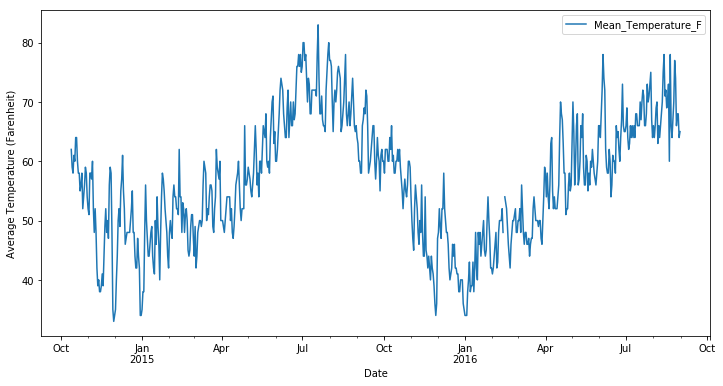

In [13]:
plt.figure(figsize=(12,6))
weather.Mean_Temperature_F.plot()
plt.legend(loc=0)
plt.ylabel('Average Temperature (Farenheit)')

In [14]:
station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 9 columns):
station_id           58 non-null object
name                 58 non-null object
lat                  58 non-null float64
long                 58 non-null float64
install_date         58 non-null datetime64[ns]
install_dockcount    58 non-null int64
modification_date    17 non-null object
current_dockcount    58 non-null int64
decommission_date    4 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 4.2+ KB


In [15]:
station.head()

station_id                    name        lat        long install_date  \
0      BT-01      3rd Ave & Broad St  47.618418 -122.350964   2014-10-13   
1      BT-03       2nd Ave & Vine St  47.615829 -122.348564   2014-10-13   
2      BT-04  6th Ave & Blanchard St  47.616094 -122.341102   2014-10-13   
3      BT-05  2nd Ave & Blanchard St  47.613110 -122.344208   2014-10-13   
4     CBD-03      7th Ave & Union St  47.610731 -122.332447   2014-10-13   

   install_dockcount modification_date  current_dockcount decommission_date  
0                 18               NaN                 18               NaN  
1                 16               NaN                 16               NaN  
2                 16               NaN                 16               NaN  
3                 14               NaN                 14               NaN  
4                 20               NaN                 20               NaN

In [16]:
marks = station
marks['install_date'] = pd.to_datetime(marks['install_date'])
marks['modification_date'] = pd.to_datetime(marks['modification_date'])
marks['decommission_date'] = pd.to_datetime(marks['decommission_date'])
marks = marks.drop(columns=['lat', 'long'])
marks.head()

station_id                    name install_date  install_dockcount  \
0      BT-01      3rd Ave & Broad St   2014-10-13                 18   
1      BT-03       2nd Ave & Vine St   2014-10-13                 16   
2      BT-04  6th Ave & Blanchard St   2014-10-13                 16   
3      BT-05  2nd Ave & Blanchard St   2014-10-13                 14   
4     CBD-03      7th Ave & Union St   2014-10-13                 20   

  modification_date  current_dockcount decommission_date  
0               NaT                 18               NaT  
1               NaT                 16               NaT  
2               NaT                 16               NaT  
3               NaT                 14               NaT  
4               NaT                 20               NaT

In [17]:
list(marks.loc[0])

['BT-01',
 '3rd Ave & Broad St',
 Timestamp('2014-10-13 00:00:00'),
 18,
 NaT,
 18,
 NaT]

In [18]:
locations = station[['lat', 'long']]
locationlist = locations.values.tolist()
print("Number of Locations: ", len(locationlist))
print("Station ID: {}, Station Name: {}, Location: {}".format(marks['station_id'][3],
                                                                 marks['name'][3], 
                                                                 locationlist[3]))

Number of Locations:  58
Station ID: BT-05, Station Name: 2nd Ave & Blanchard St, Location: [47.61311, -122.34420800000001]


In [41]:
cycle_map=folium.Map(location=[station.lat.mean(),station.long.mean()],
                          zoom_start=12.5,tiles='OpenStreetMap')
for point in range(0, len(locationlist)):
    folium.CircleMarker(locationlist[point], popup=folium.Popup((marks.loc[point]['name']))
                            , fill=True).add_to(cycle_map)
    cycle_map.save(os.path.join('Maps/', 'bike_map_1.html'))
    plugins.ScrollZoomToggler().add_to(cycle_map)
cycle_map

In [40]:
clusters=folium.Map(location=[station.lat.mean(),station.long.mean()],
                      zoom_start=12.5,tiles='OpenStreetMap')
plugins.MarkerCluster(locationlist).add_to(clusters)
plugins.ScrollZoomToggler().add_to(clusters)
clusters.save(os.path.join('Maps/', 'clusters_map_1.html'))
clusters

In [21]:
if (not os.path.exists('Maps/bike_map_2.html')):
    cycle_map=folium.Map(location=[station.lat.median(),station.long.median()],
                          zoom_start=12,tiles='OpenStreetMap')
    for point in range(0, len(locationlist)):
        folium.Marker(locationlist[point],
              popup=folium.Popup((marks.loc[point]['name'])),
              icon=folium.Icon(color='blue', icon='bicycle', prefix='fa')
             ).add_to(cycle_map)
        plugins.ScrollZoomToggler().add_to(cycle_map)
    cycle_map.save(os.path.join('Maps/', 'bike_map_2.html'))
cycle_map

In [22]:
trip.head()

trip_id           starttime            stoptime    bikeid    tripduration  \
0      431 2014-10-13 10:31:00 2014-10-13 10:48:00  SEA00298 00:16:25.935000   
1      432 2014-10-13 10:32:00 2014-10-13 10:48:00  SEA00195 00:15:26.375000   
2      433 2014-10-13 10:33:00 2014-10-13 10:48:00  SEA00486 00:14:43.831000   
3      434 2014-10-13 10:34:00 2014-10-13 10:48:00  SEA00333 00:14:25.937000   
4      435 2014-10-13 10:34:00 2014-10-13 10:49:00  SEA00202 00:15:23.923000   

     from_station_name                                    to_station_name  \
0  2nd Ave & Spring St  Occidental Park / Occidental Ave S & S Washing...   
1  2nd Ave & Spring St  Occidental Park / Occidental Ave S & S Washing...   
2  2nd Ave & Spring St  Occidental Park / Occidental Ave S & S Washing...   
3  2nd Ave & Spring St  Occidental Park / Occidental Ave S & S Washing...   
4  2nd Ave & Spring St  Occidental Park / Occidental Ave S & S Washing...   

  from_station_id to_station_id usertype  gender  birthyear  
0          CBD-06         PS-04   Member    Male     1960.0  
1          CBD-06         PS-04   Member    Male     1970.0  
2          CBD-06         PS-04   Member  Female     1988.0  
3          CBD-06         PS-04   Member  Female     1977.0  
4          CBD-06         PS-04   Member    Male     1971.0

In [23]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286857 entries, 0 to 286856
Data columns (total 12 columns):
trip_id              286857 non-null int64
starttime            286857 non-null datetime64[ns]
stoptime             286857 non-null datetime64[ns]
bikeid               286857 non-null object
tripduration         286857 non-null timedelta64[ns]
from_station_name    286857 non-null object
to_station_name      286857 non-null object
from_station_id      286857 non-null object
to_station_id        286857 non-null object
usertype             286857 non-null object
gender               181557 non-null object
birthyear            181553 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(1), object(7), timedelta64[ns](1)
memory usage: 26.3+ MB


In [24]:
trip.sort_values(by='from_station_name', inplace=True)
trip.reset_index(drop=True, inplace=True)
trip.head()

trip_id           starttime            stoptime    bikeid    tripduration  \
0   150538 2015-09-28 08:06:00 2015-09-28 08:15:00  SEA00455 00:08:45.250000   
1   144644 2015-09-15 07:35:00 2015-09-15 07:42:00  SEA00236 00:06:50.886000   
2    93435 2015-06-19 08:17:00 2015-06-19 08:31:00  SEA00472 00:13:44.889000   
3    93437 2015-06-19 08:19:00 2015-06-19 08:25:00  SEA00261 00:05:34.810000   
4    54937 2015-04-06 16:52:00 2015-04-06 17:02:00  SEA00472 00:09:58.422000   

        from_station_name                  to_station_name from_station_id  \
0  12th Ave & E Denny Way            9th Ave N & Mercer St           CH-06   
1  12th Ave & E Denny Way                2nd Ave & Pine St           CH-06   
2  12th Ave & E Denny Way  Pier 69 / Alaskan Way & Clay St           CH-06   
3  12th Ave & E Denny Way                2nd Ave & Pine St           CH-06   
4  12th Ave & E Denny Way                2nd Ave & Pine St           CH-06   

  to_station_id usertype gender  birthyear  
0        DPD-01   Member   Male     1986.0  
1        CBD-13   Member   Male     1979.0  
2         WF-01   Member   Male     1984.0  
3        CBD-13   Member   Male     1985.0  
4        CBD-13   Member   Male     1985.0

In [25]:
from_st = trip.from_station_name.unique()
stations = station.name.unique()
for i in from_st:
     if i not in stations:
            print(i, "is not a station")

8D OPS 02 is not a station
Pronto shop is not a station
Pronto shop 2 is not a station


In [26]:
trip[trip['from_station_name'] == '8D OPS 02']

trip_id           starttime            stoptime    bikeid  \
84709   246674 2016-08-12 09:06:00 2016-08-12 09:08:00  SEA99997   
84710   246671 2016-08-12 09:03:00 2016-08-12 09:06:00  SEA99997   

         tripduration from_station_name to_station_name from_station_id  \
84709 00:01:30.845000         8D OPS 02       8D OPS 02       8D OPS 02   
84710 00:02:56.390000         8D OPS 02       8D OPS 02       8D OPS 02   

      to_station_id                usertype gender  birthyear  
84709     8D OPS 02  Short-Term Pass Holder    NaN        NaN  
84710     8D OPS 02  Short-Term Pass Holder    NaN        NaN

In [27]:
trip[trip['from_station_name'] == 'Pronto shop']

trip_id           starttime            stoptime    bikeid  \
226752    83795 2015-06-02 20:36:00 2015-06-02 20:43:00  SEA00093   

          tripduration from_station_name         to_station_name  \
226752 00:06:38.726000       Pronto shop  2nd Ave & Blanchard St   

       from_station_id to_station_id usertype gender  birthyear  
226752     Pronto shop         BT-05   Member   Male     1993.0

In [28]:
trip[trip['from_station_name'] == 'Pronto shop 2']

trip_id           starttime            stoptime    bikeid  \
226753   210449 2016-05-17 15:41:00 2016-05-17 15:42:00  SEA00475   
226754   210328 2016-05-17 12:03:00 2016-05-17 12:04:00  SEA00421   

          tripduration from_station_name to_station_name from_station_id  \
226753 00:01:05.702000     Pronto shop 2   Pronto shop 2   Pronto shop 2   
226754 00:01:32.313000     Pronto shop 2   Pronto shop 2   Pronto shop 2   

        to_station_id usertype  gender  birthyear  
226753  Pronto shop 2   Member  Female     1989.0  
226754  Pronto shop 2   Member    Male     1992.0

In [29]:
drops = [84709, 84710, 226752, 226753, 226754]
for drop in drops:
    (trip.drop(index=drop, inplace=True))
    print("Dropped row", drop, "because the station was not in the station list")

Dropped row 84709 because the station was not in the station list
Dropped row 84710 because the station was not in the station list
Dropped row 226752 because the station was not in the station list
Dropped row 226753 because the station was not in the station list
Dropped row 226754 because the station was not in the station list


In [30]:
trip.from_station_name.nunique() == station.name.nunique()

True

In [31]:
station.head()

station_id                    name        lat        long install_date  \
0      BT-01      3rd Ave & Broad St  47.618418 -122.350964   2014-10-13   
1      BT-03       2nd Ave & Vine St  47.615829 -122.348564   2014-10-13   
2      BT-04  6th Ave & Blanchard St  47.616094 -122.341102   2014-10-13   
3      BT-05  2nd Ave & Blanchard St  47.613110 -122.344208   2014-10-13   
4     CBD-03      7th Ave & Union St  47.610731 -122.332447   2014-10-13   

   install_dockcount modification_date  current_dockcount decommission_date  
0                 18               NaT                 18               NaT  
1                 16               NaT                 16               NaT  
2                 16               NaT                 16               NaT  
3                 14               NaT                 14               NaT  
4                 20               NaT                 20               NaT

In [32]:
trip.head()

trip_id           starttime            stoptime    bikeid    tripduration  \
0   150538 2015-09-28 08:06:00 2015-09-28 08:15:00  SEA00455 00:08:45.250000   
1   144644 2015-09-15 07:35:00 2015-09-15 07:42:00  SEA00236 00:06:50.886000   
2    93435 2015-06-19 08:17:00 2015-06-19 08:31:00  SEA00472 00:13:44.889000   
3    93437 2015-06-19 08:19:00 2015-06-19 08:25:00  SEA00261 00:05:34.810000   
4    54937 2015-04-06 16:52:00 2015-04-06 17:02:00  SEA00472 00:09:58.422000   

        from_station_name                  to_station_name from_station_id  \
0  12th Ave & E Denny Way            9th Ave N & Mercer St           CH-06   
1  12th Ave & E Denny Way                2nd Ave & Pine St           CH-06   
2  12th Ave & E Denny Way  Pier 69 / Alaskan Way & Clay St           CH-06   
3  12th Ave & E Denny Way                2nd Ave & Pine St           CH-06   
4  12th Ave & E Denny Way                2nd Ave & Pine St           CH-06   

  to_station_id usertype gender  birthyear  
0        DPD-01   Member   Male     1986.0  
1        CBD-13   Member   Male     1979.0  
2         WF-01   Member   Male     1984.0  
3        CBD-13   Member   Male     1985.0  
4        CBD-13   Member   Male     1985.0

In [33]:
from_list = trip.from_station_id.unique()

In [34]:
trip_dict = {}
for i in from_list:
    df = trip.loc[trip['from_station_id'] == i]
    trip_dict[i] = {}
    trip_dict[i]['total output'] = len(df)
    df1 = trip.loc[trip['to_station_id'] == i]
    trip_dict[i]["total input"] = len(df1)
    for s in df['to_station_id'].unique():
        trip_dict[i]['to_{}'.format(s)] = len(df[df['to_station_id']==s])
    trip_dict[i]['avg_duration'] = (df['tripduration'].mean())

In [35]:
(trip_dict)

{'CH-06': {'total output': 3837,
  'total input': 1234,
  'to_DPD-01': 118,
  'to_CBD-13': 185,
  'to_WF-01': 32,
  'to_SLU-07': 194,
  'to_ID-04': 157,
  'to_CH-05': 35,
  'to_EL-01': 70,
  'to_CBD-07': 192,
  'to_CH-07': 41,
  'to_SLU-16': 401,
  'to_SLU-20': 18,
  'to_FH-01': 21,
  'to_CH-08': 314,
  'to_CBD-05': 175,
  'to_CH-01': 81,
  'to_CD-01': 55,
  'to_UD-01': 5,
  'to_CBD-06': 67,
  'to_SLU-01': 64,
  'to_SLU-04': 183,
  'to_SLU-15': 93,
  'to_CH-12': 121,
  'to_PS-04': 103,
  'to_CH-02': 183,
  'to_CH-15': 155,
  'to_SLU-18': 7,
  'to_CH-06': 87,
  'to_BT-03': 19,
  'to_UW-10': 11,
  'to_CH-09': 95,
  'to_PS-05': 61,
  'to_SLU-19': 20,
  'to_BT-01': 21,
  'to_CH-03': 21,
  'to_CBD-03': 97,
  'to_FH-04': 123,
  'to_CBD-04': 11,
  'to_BT-04': 9,
  'to_UD-04': 21,
  'to_UW-04': 5,
  'to_BT-05': 29,
  'to_SLU-02': 7,
  'to_SLU-17': 22,
  'to_CH-16': 26,
  'to_EL-05': 34,
  'to_UD-07': 9,
  'to_WF-04': 11,
  'to_EL-03': 10,
  'to_UW-11': 1,
  'to_UD-02': 4,
  'to_DPD-03': 3,
  '

In [36]:
marks.head()

station_id                    name install_date  install_dockcount  \
0      BT-01      3rd Ave & Broad St   2014-10-13                 18   
1      BT-03       2nd Ave & Vine St   2014-10-13                 16   
2      BT-04  6th Ave & Blanchard St   2014-10-13                 16   
3      BT-05  2nd Ave & Blanchard St   2014-10-13                 14   
4     CBD-03      7th Ave & Union St   2014-10-13                 20   

  modification_date  current_dockcount decommission_date  
0               NaT                 18               NaT  
1               NaT                 16               NaT  
2               NaT                 16               NaT  
3               NaT                 14               NaT  
4               NaT                 20               NaT

In [37]:
locationlist[:5]

[[47.618418, -122.35096399999999],
 [47.615829, -122.348564],
 [47.616094, -122.341102],
 [47.61311, -122.34420800000001],
 [47.610731, -122.332447]]

In [38]:
for k, v in trip_dict.items():
        print("Station: ", k)
        print("Total Trips Leaving: ", v['total output'])
        print("Total Trips Arriving: ", v['total input'])
        break

Station:  CH-06
Total Trips Leaving:  3837
Total Trips Arriving:  1234


In [46]:
#if (not os.path.exists('Maps/bike_map_3.html')):
cycle_map=folium.Map(location=[station.lat.median(),station.long.median()],
                      zoom_start=12,tiles='OpenStreetMap')
for point in range(0, len(locationlist)):
    for k, v in trip_dict.items():
        folium.Marker(locationlist[point],
              popup=folium.Popup((marks.loc[point]['name'])),
              icon=folium.Icon(color='blue', icon='bicycle', prefix='fa')
             ).add_to(cycle_map)

#     fg = folium.FeatureGroup(name='All Groups')
#     cycle_map.add_child(fg)
#     for station in trip_dict:
#         print(station)
#     g1 = plugins.FeatureGroupSubGroup(fg, 'Districts')
#     cycle_map.add_child(g1)
#     g2 = plugins.FeatureGroupSubGroup(fg, 'Clusters')
#     cycle_map.add_child(g2)

# for k, v in (z_dict.items()):
#     folium.Marker([v['Lat'], v['Long']], popup=folium.Popup(v["Top 5"], max_width=200), 
#                   tooltip=("District: "+str(k))).add_to(g1)
plugins.ScrollZoomToggler().add_to(cycle_map)
cycle_map.save(os.path.join('Maps/', 'bike_map_3.html'))
cycle_map

In [54]:
station.install_date.describe()

count                      58
unique                      9
top       2014-10-13 00:00:00
freq                       50
first     2014-10-13 00:00:00
last      2016-08-09 00:00:00
Name: install_date, dtype: object

In [78]:
trip.from_station_id.value_counts().describe()

count       58.000000
mean      4945.724138
std       3021.970182
min        160.000000
25%       2690.000000
50%       4922.500000
75%       6521.250000
max      13054.000000
Name: from_station_id, dtype: float64

In [31]:
# # Folium plugin for full screen option to be rendered on map

# plugins.Fullscreen(
#     position='topright',
#     title='Expand me',
#     title_cancel='Exit me',
#     force_separate_button=True
# ).add_to(m)